<a href="https://colab.research.google.com/github/manhhad32/nlp/blob/master/att-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler




In [15]:
# Load your dataset
data = pd.read_csv('/content/data/electric_load_data.csv', parse_dates=['timestamp'])

# Handle missing values
data = data.fillna(method='ffill')  # Forward fill for missing values

# Feature engineering
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month

# Lag features
data['lag_1'] = data['electric_load'].shift(1)
data['lag_24'] = data['electric_load'].shift(24)
data = data.dropna()  # Drop rows with NaN values after shifting

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['electric_load', 'hour', 'day_of_week', 'month', 'lag_1', 'lag_24']])
scaled_data = pd.DataFrame(scaled_features, columns=['electric_load', 'hour', 'day_of_week', 'month', 'lag_1', 'lag_24'])

# Prepare sliding windows for LSTM
window_size = 24
X, y = [], []

for i in range(len(scaled_data) - window_size):
    X.append(scaled_data.iloc[i:i + window_size].values)
    y.append(scaled_data.iloc[i + window_size]['electric_load'])

X, y = np.array(X), np.array(y)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-15-344c91f7ca4e>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')  # Forward fill for missing values


In [23]:
def create_att_lstm_model(input_shape):
    inputs = Input(shape=input_shape)

    # LSTM layer
    lstm_out, state_h, state_c = LSTM(64, return_sequences=True, return_state=True)(inputs)

    # Attention layer
    attention = Attention()([lstm_out, lstm_out])

    # Concatenate LSTM output and attention output
    lstm_attention = Concatenate()([lstm_out, attention])

    # Dropout for regularization
    lstm_attention = Dropout(0.2)(lstm_attention)

    # Flatten and Dense layer for output
    lstm_attention = tf.keras.layers.Flatten()(lstm_attention)
    outputs = Dense(1)(lstm_attention)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Initialize model
input_shape = (X_train.shape[1], X_train.shape[2])
model = create_att_lstm_model(input_shape)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 24, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 24, 64),       │         18,176 │ input_layer_2[0][0]    │
│                           │ (None, 64), (None,     │                │                        │
│                           │ 64)]                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_2 (Attention)   │ (None, 24, 64)         │              0 │ lstm_2[0][0],          │
│                           │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 24, 128)        │              0 │ lstm_2[0][0],          │
│ (Concatenate)             │                        │                │ attention_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 24, 128)        │              0 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3072)           │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          3,073 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.2201 - val_loss: 0.0979
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0971 - val_loss: 0.0993
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1033 - val_loss: 0.0894
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1054 - val_loss: 0.0983
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1020 - val_loss: 0.0875
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0931 - val_loss: 0.0892
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0920 - val_loss: 0.0884
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0943 - val_loss: 0.0886
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0935 - val_loss: 0.0891
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0859 - val_loss: 0.0891
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0958 - val_loss: 0.0904
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

In [28]:
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')


Test Loss: 0.1007


In [29]:
# Predict using the model
y_pred = model.predict(X_test)

# Convert predictions back to original scale if needed (if data was normalized)
# y_pred = scaler.inverse_transform(y_pred)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


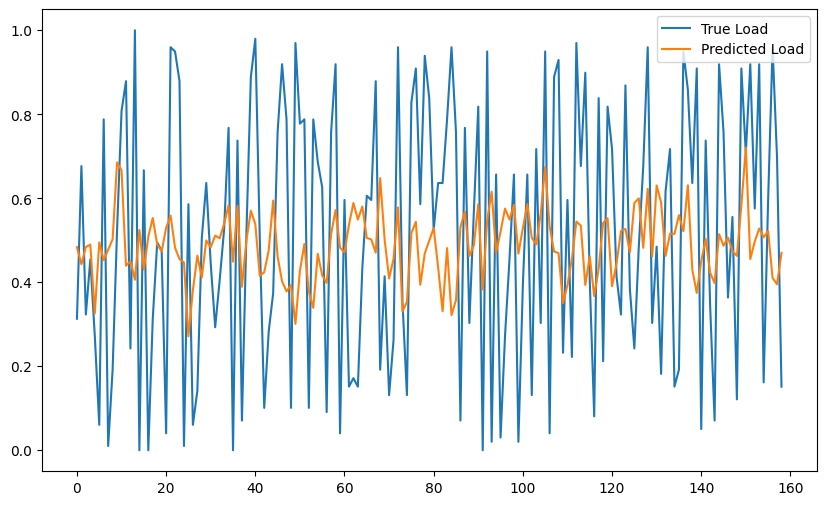

In [30]:
y_pred = model.predict(X_test)

# Convert predictions back to original scale if needed
# y_pred = scaler.inverse_transform(y_pred)

# Example of comparing predictions with true values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Load')
plt.plot(y_pred, label='Predicted Load')
plt.legend()
plt.show()